# Modelling of Physical Systems lab 3
## Stanisław Borowy 

Goal of the following lab is to analyze how difference between analytic and numeric solution changes with respect to chosen time step
$dt$. Upwind scheme will serve as numeric approach, whereas $\psi_0 (x - ut)$ is used as an analytic one. Difference will be calculated as a Root Mean Squared Error (RMSE) - a popular error metric. RMSE is defined by the following equation

$$
RMSE = \sqrt{\frac{1}{n}\sum^n_{i=1}(y_i - \hat{y_i})^2},
$$

where $n$ - number of samples, $y$ - true value, $\hat{y}$ - predicted value. For purposes of this analysis it does not matter whether we assume numeric solution to be $y$ or $\hat{y}$, they can be labeled interchangably.


In [3]:
from open_atmos_jupyter_utils import show_plot

1. Necessary definitions

In [4]:
import numpy as np

class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

def F(psiL, psiR, C):
    return ((C + abs(C)) / 2) * psiL + ((C - abs(C)) / 2) * psiR

class One:
    def __radd__(self, o):
        return slice(o.start + 1, o.stop + 1)

    def __rsub__(self, o):
        return slice(o.start - 1, o.stop - 1)

*Note: even though the end goal is to analyze how choice of $dt$ affects the RMSE, Python functions are defined in terms of $nt$ - number of time steps, which is easier to work with in implementation stage*

*Note 2: Variables named in upper case are arbitrarily chosen constants*

In [5]:
T_MAX = 50
U = 2
NX = 64
C = 0.8
SPACE_START = -100

nt = 20

def x_range(dx):
    return np.arange(SPACE_START, SPACE_START + dx * NX, dx)

def upwind_scheme(nt):
    psi_0 = Psi_0()
    one = One()

    dt = T_MAX / nt
    dx = (U * dt) / C

    x = x_range(dx)

    psi = psi_0(x)
    i = slice(1, NX - 2)

    for _ in range(nt):
        psi[i] = psi[i] - (F(psi[i], psi[i + one], C) - F(psi[i - one], psi[i], C))

    return psi

def analytical_solution(nt):
    psi_0 = Psi_0()

    dt = T_MAX / nt
    dx = (U * dt) / C

    x = x_range(dx)

    return psi_0(x - U * T_MAX)

RMSE implementation

In [6]:
def rmse(y_pred, y_true):
    return np.sqrt(np.sum((y_pred - y_true) ** 2) / len(y_true))

analytical = analytical_solution(nt)
numerical = upwind_scheme(nt)

rmse(numerical, analytical)

0.025726679669951086

Calculation RMSE for many values of dt

In [7]:
nts = list(range(10, 200, 2))
numerical_solutions = [upwind_scheme(nt) for nt in nts]
analytical_solutions = [analytical_solution(nt) for nt in nts]
rmses = [rmse(numerical, analytical) for analytical, numerical in zip(analytical_solutions, numerical_solutions)]
rmses[:10]

[0.0330862505304698,
 0.03111962966892328,
 0.02946364709544146,
 0.028044651978363633,
 0.02681134143381517,
 0.025726679669951086,
 0.024763170174630828,
 0.023899918716638734,
 0.023120495808678334,
 0.02248915796429921]

Plotting RMSE in terms of dt

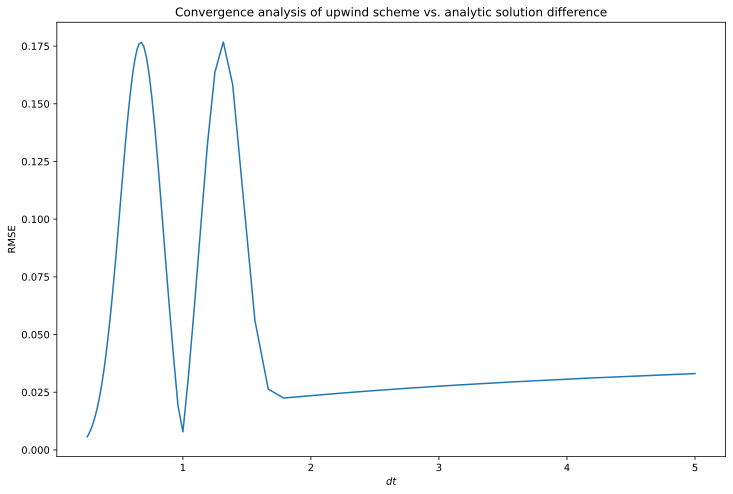

In [8]:
import matplotlib.pyplot as plt

dts = [T_MAX / nt for nt in nts]

plt.figure(figsize=(12, 8))
plt.title("Convergence analysis of upwind scheme vs. analytic solution difference")
plt.xlabel("$dt$")
plt.ylabel("RMSE")

plt.plot(dts, rmses)
show_plot("rmse.pdf")

## Conclusions

Above plot has clearly visible elbow $dt_{el}$. For values of $dt > dt_{el}$ RMSE increases in propotion to $dt$, which is expected. More interestingly, RMSE alternates between sharp increase and decrese for values $dt < dt_{el}$, which implies some sort of instability.